## Cross Validation con LightGBM

In [1]:
import pandas as pd

dataset_work_3 = pd.read_csv('D:\DataSet\dataset_work_transformed.csv')
x = dataset_work_3.iloc[:,:-1]
y = dataset_work_3.iloc[:,-1].values
dataset_work_3.shape

(6435823, 16)

[LightGBM] [Info] Number of positive: 944693, number of negative: 1307845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2219
[LightGBM] [Info] Number of data points in the train set: 2252538, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419390 -> initscore=-0.325276
[LightGBM] [Info] Start training from score -0.325276
[LightGBM] [Info] Number of positive: 944693, number of negative: 1307845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2155
[LightGBM] [Info] Number of data points in the train set: 2252538, number of used features: 15
[LightGB

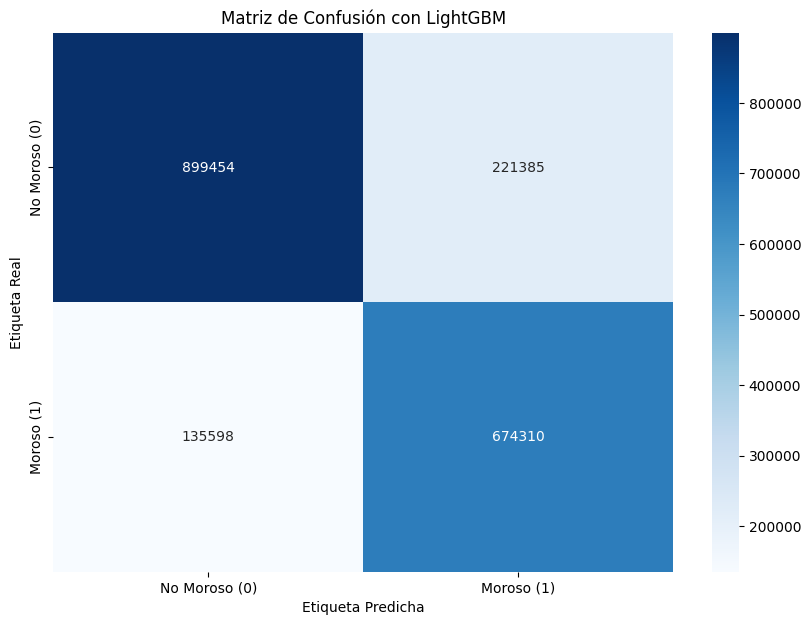

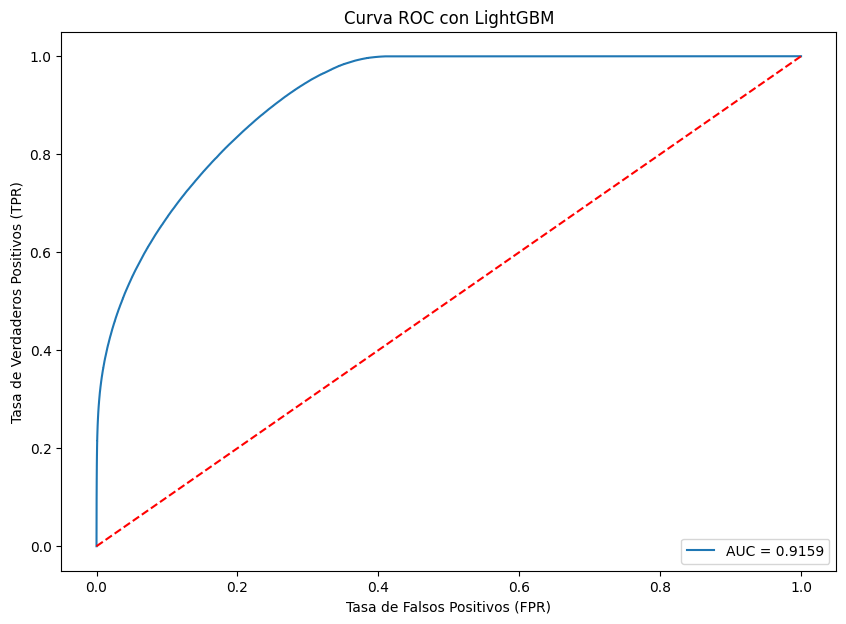

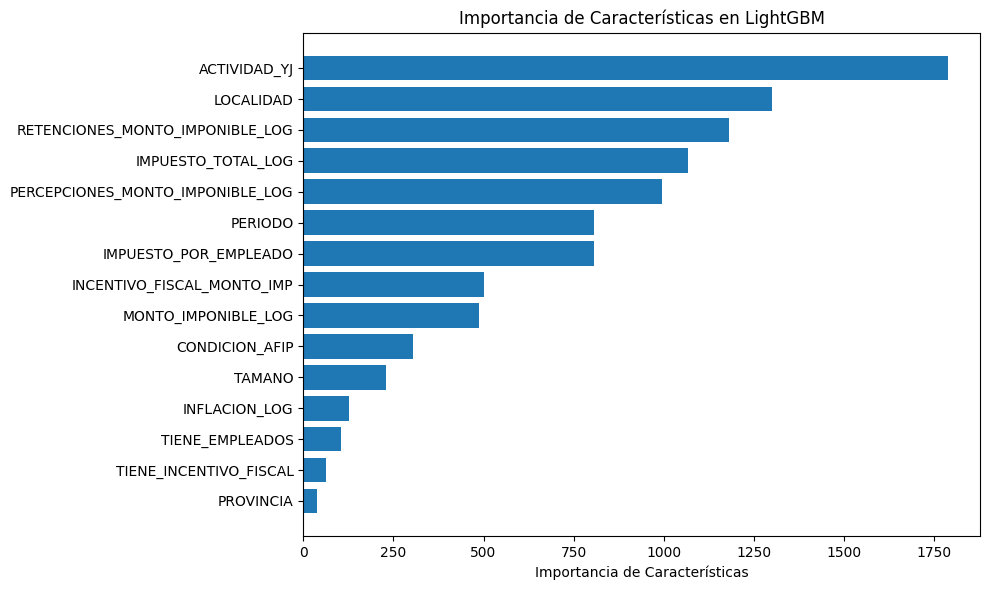

El tiempo total de ejecución fue de 3 minutos y 42.86 segundos.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Registro del tiempo de inicio
start_time = time.time()

# Definir las características y la variable objetivo  //df_mora_prestamos
X = dataset_work_3.drop(columns=["MOROSIDAD"])
y = dataset_work_3["MOROSIDAD"]

# Separar el dataset en conjunto de entrenamiento (30%) y test (70%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hiperparámetros óptimos (asumiendo que ya los has encontrado)
best_params = {
    'subsample': 1.0,
    'num_leaves': 50,
    'n_estimators': 200,
    'min_child_samples': 30,
    'max_depth': 20,
    'learning_rate': 0.2,
    'colsample_bytree': 0.8,
}


# Crear el modelo con los hiperparámetros óptimos
clf_lightgbm = LGBMClassifier(**best_params)

# Realizar la validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(clf_lightgbm, X_train, y_train, cv=2, scoring='accuracy')
print(f"Validación Cruzada (Acuracidad) - Media: {cv_scores.mean():.4f}, Desviación Estándar: {cv_scores.std():.4f}")

# Entrenar el modelo con los datos sin balancear
clf_lightgbm.fit(X_train, y_train)

# Predecir en los datos de prueba
y_pred_lightgbm = clf_lightgbm.predict(X_test)
probs_lightgbm = clf_lightgbm.predict_proba(X_test)
preds_lightgbm = probs_lightgbm[:, 1]

# Calcular métricas de evaluación en el conjunto de prueba
fpr_test, tpr_test, threshold_test = roc_curve(y_test, preds_lightgbm)
roc_auc_test = auc(fpr_test, tpr_test)

print("Resultados en el Conjunto de Prueba:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lightgbm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lightgbm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lightgbm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lightgbm):.4f}")
print(f"AUC (Prueba): {roc_auc_test:.4f}")

# Reporte de Clasificación

print("Reporte de Clasificación LightGBM:")
print(classification_report(y_test, y_pred_lightgbm))


# Matriz de Confusión
cm_lightgbm = confusion_matrix(y_test, y_pred_lightgbm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lightgbm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Moroso (0)', 'Moroso (1)'], yticklabels=['No Moroso (0)', 'Moroso (1)'])
plt.title("Matriz de Confusión con LightGBM")
plt.ylabel("Etiqueta Real")
plt.xlabel("Etiqueta Predicha")
plt.show()

# Curva ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr_test, tpr_test, label=f'AUC = {roc_auc_test:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.title('Curva ROC con LightGBM')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

# Importancia de Características
feature_importance = clf_lightgbm.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sorted_idx = feature_importance.argsort()
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Importancia de Características')
plt.title('Importancia de Características en LightGBM')
plt.tight_layout()
plt.show()


# Medir el tiempo de finalización y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time

# Convertir a minutos y segundos
minutes = elapsed_time // 60
seconds = elapsed_time % 60

print(f"El tiempo total de ejecución fue de {int(minutes)} minutos y {seconds:.2f} segundos.")